In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
# import regionmask
import rioxarray
from shapely.geometry import mapping # , Point, Polygon
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pprint

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# Data file paths
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc' # Data containing regridded flux and SSH for 150 years
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson' # File contains all defined ice shelves
figures_folderpath = 'reports/figures/' # Folder for output figures

In [3]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh
lat = data.lat
lon = data.lon

In [4]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

In [5]:
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'})
crs = ccrs.SouthPolarStereo()

# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True)

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<xarray.Dataset>
Dimensions:                                (y: 601, x: 601, time: 1800)
Coordinates:
    lat                                    (y, x) float64 ...
    lon                                    (y, x) float64 ...
  * time                                   (time) datetime64[ns] 2001-01-31 ....
  * x                                      (x) float64 -3e+06 ... 3e+06
  * y                                      (y) float64 -3e+06 ... 3e+06
    spatial_ref                            int64 0
Data variables:
    timeMonthly_avg_landIceFreshwaterFlux  (time, y, x) float64 ...
    timeMonthly_avg_ssh                    (time, y, x) float64 ...
Attributes:
    history:   Wed Oct 27 15:35:43 2021: ncrcat RegriddedFluxSSH.0001-01-01.n...
    meshName:  6000.0x6000.0km_10.0km_Antarctic_stereo
    NCO:       netCDF Operators version 5.0.3 (Homepage = http://nco.sf.net, ...

In [6]:
## Following section tests the code for 1 ice shelf / catchment:
# Iceshelf chosen: 
#  34 : Amery
# 103 : Ronne
# 104 : Western Ross
# 105 : Eastern Ross
# 114 : Thwaites

basin = 114
basinName = icems.name.values[basin]

In [8]:
# Mask data to chosen basin
ds = data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)


KeyboardInterrupt



In [9]:
flx = ds.timeMonthly_avg_landIceFreshwaterFlux
h = ds.timeMonthly_avg_ssh

In [10]:
flx_ts = flx.sum(['y','x'])

In [11]:
# Remove climatologies to isolate anomalies / deseasonalize 
flx_monthly = flx.groupby("time.month")
flx_clm = flx_monthly.mean("time") # Climatologies
flx_anm = flx_monthly - flx_clm # Deseasonalized anomalies

# Integrate over entire AIS / basin for time series
flx_clm_ts = flx_clm.sum(['y','x']) # Seasonality / Climatology?
flx_anm_ts = flx_anm.sum(['y','x'], skipna=True)

Text(0.5, 0, 'Month')

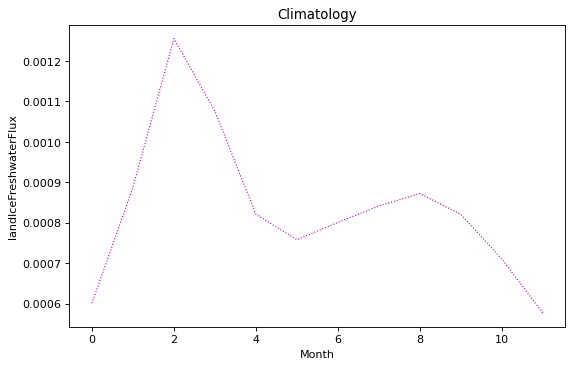

In [12]:
# Annual Climatology
plt.figure(figsize=(8, 5), dpi=80)
plt.title('Climatology')
plt.plot(flx_clm_ts,color='m', linestyle='dotted', linewidth=1)
plt.ylabel('landIceFreshwaterFlux')
plt.xlabel('Month')

In [13]:
def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

In [14]:
# Remove linear trend from the deseasonalized anomalies
flx_dtr = detrend_dim(flx_anm, 'time', 1)

In [15]:
# Integrate flux across basin for time series
flx_dtr_ts = flx_dtr.sum(['y','x'], skipna=True)

In [16]:
flx_snl_ts = flx_ts - flx_anm_ts # Seasonality trend
flx_lnr_ts = flx_anm_ts - flx_dtr_ts # Linear trend

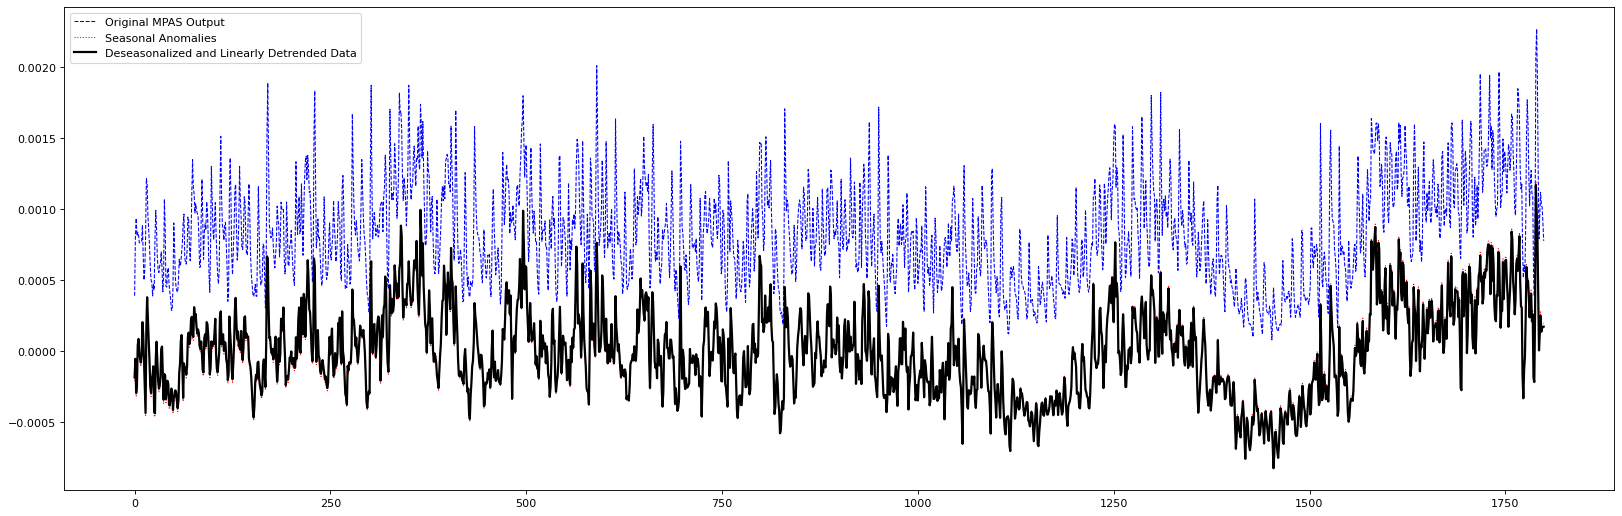

In [17]:
plt.figure(figsize=(25, 8), dpi=80)
plt.plot(flx_ts, label='Original MPAS Output', color='b', linestyle='--', linewidth=0.95)
plt.plot(flx_anm_ts, label='Seasonal Anomalies', color='r', linestyle='dotted', linewidth=0.95)
plt.plot(flx_dtr_ts, label='Deseasonalized and Linearly Detrended Data', color='k', linewidth=2)
plt.legend()

Text(0.5, 1.0, '')

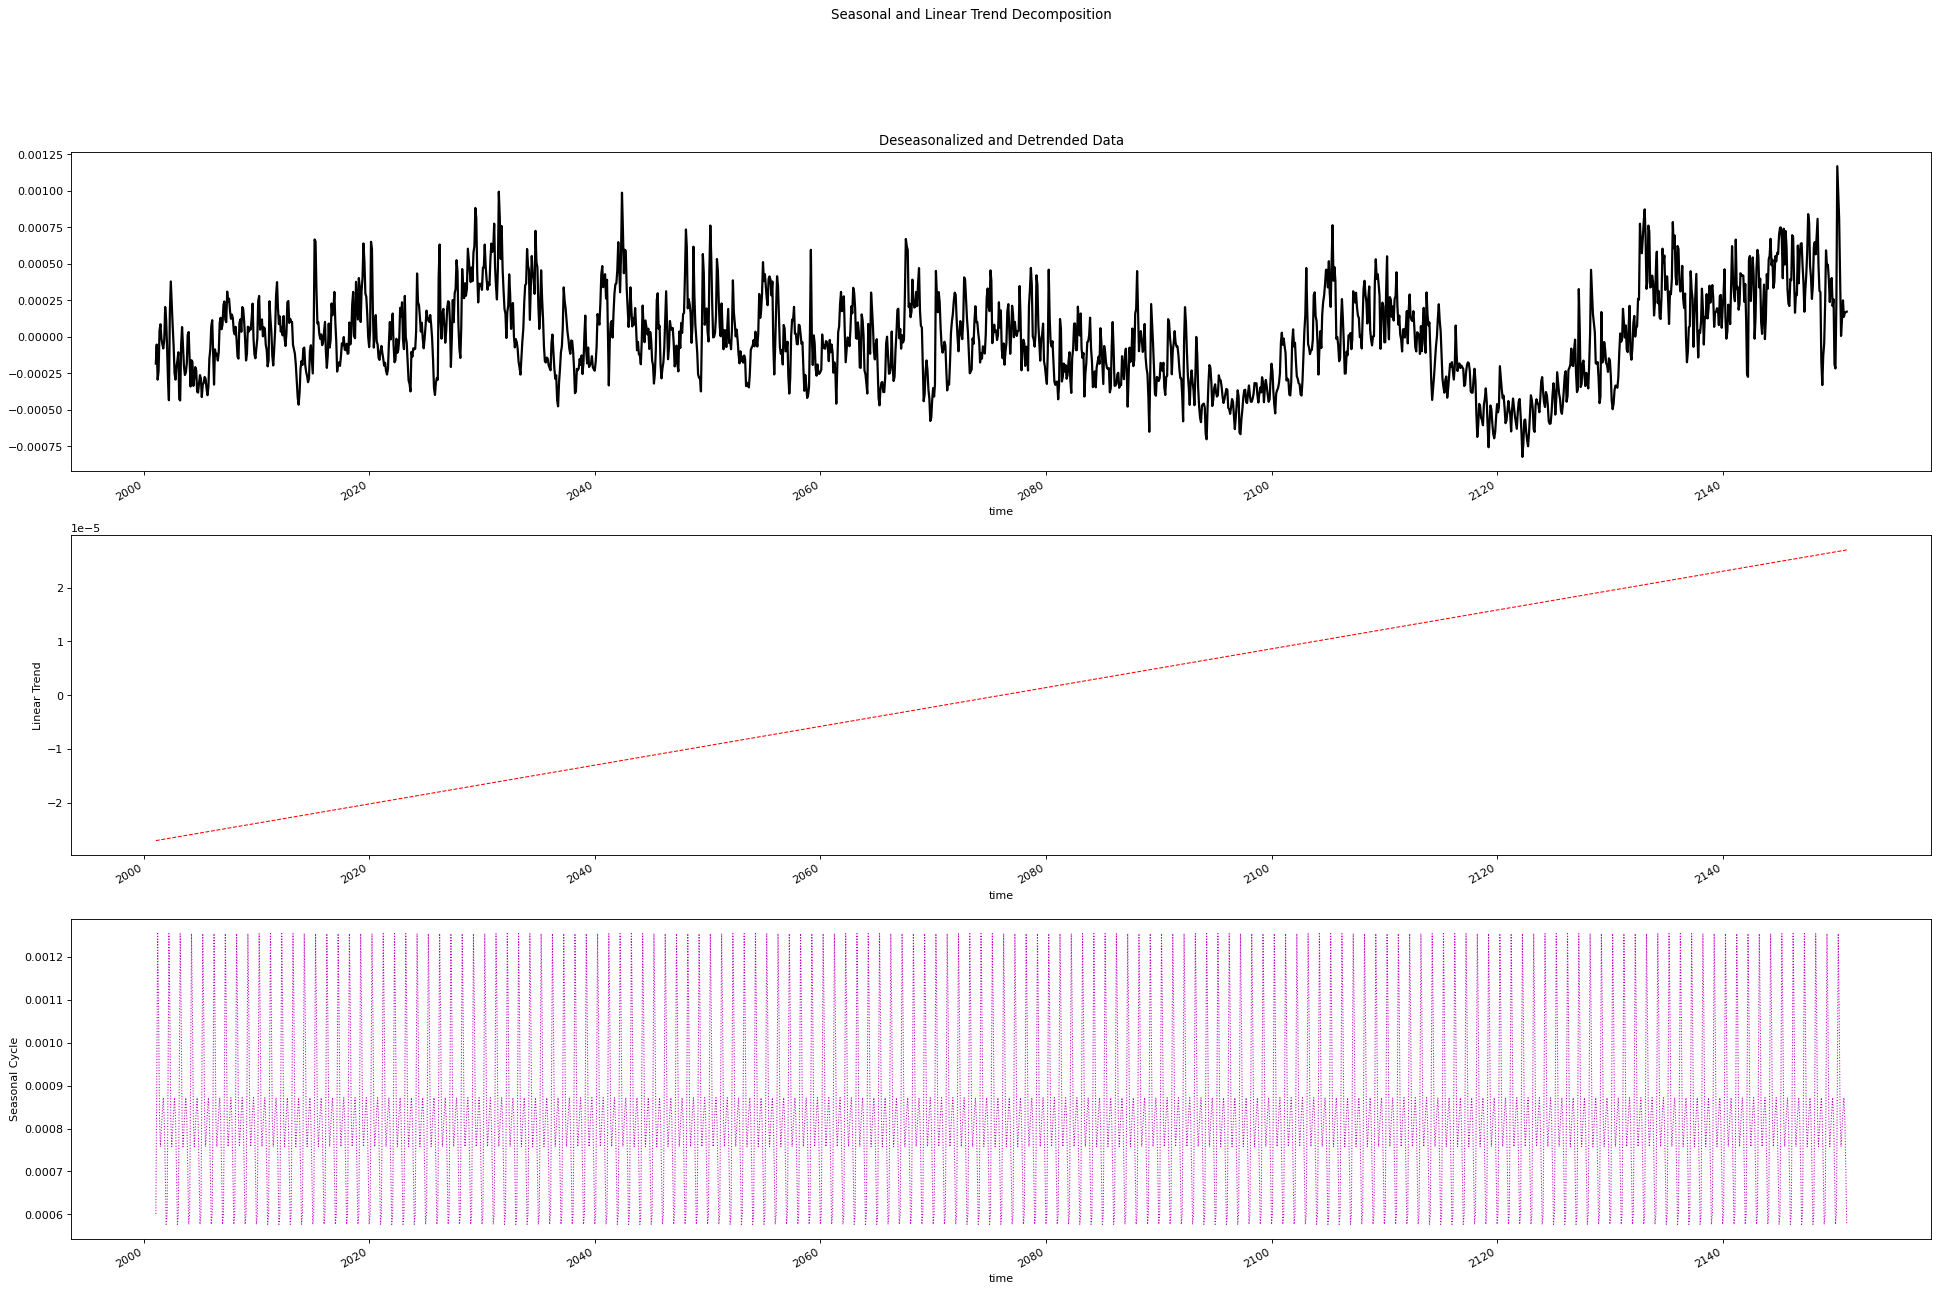

In [18]:
# Seasonal and Linear Trend Decomposition

plt.subplots(3, figsize=(30, 18), dpi=80)
plt.suptitle('Seasonal and Linear Trend Decomposition')

plt.subplot(311)
flx_dtr_ts.plot(color='k', linewidth=2)
plt.title('Deseasonalized and Detrended Data')

plt.subplot(312)
flx_lnr_ts.plot(color='r', linestyle='--', linewidth=0.95)
plt.ylabel('Linear Trend')
plt.title('')

plt.subplot(313)
flx_snl_ts.plot(color='m', linestyle='dotted', linewidth=0.95)
plt.ylabel('Seasonal Cycle')
plt.title('')

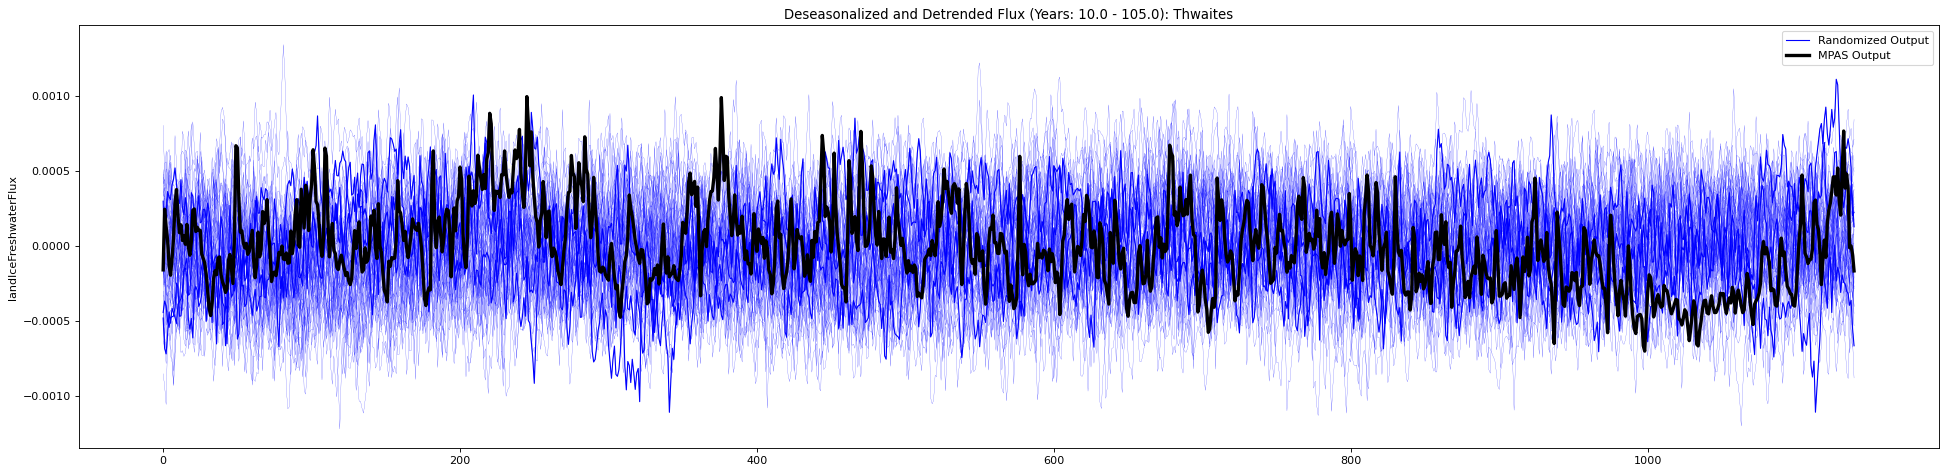

In [19]:
# Plot phase randomized data
plt.figure(figsize=(30, 7), dpi=80)

spinuptime = 60 # Ignore first few years of data in the phase randomization
n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx_dtr_ts[spinuptime:].size))

# Time limits for plotting
t1 = 60
tf = 1200

for i in range(n_realizations):    
    fl = flx_dtr_ts[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    # random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)
    random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

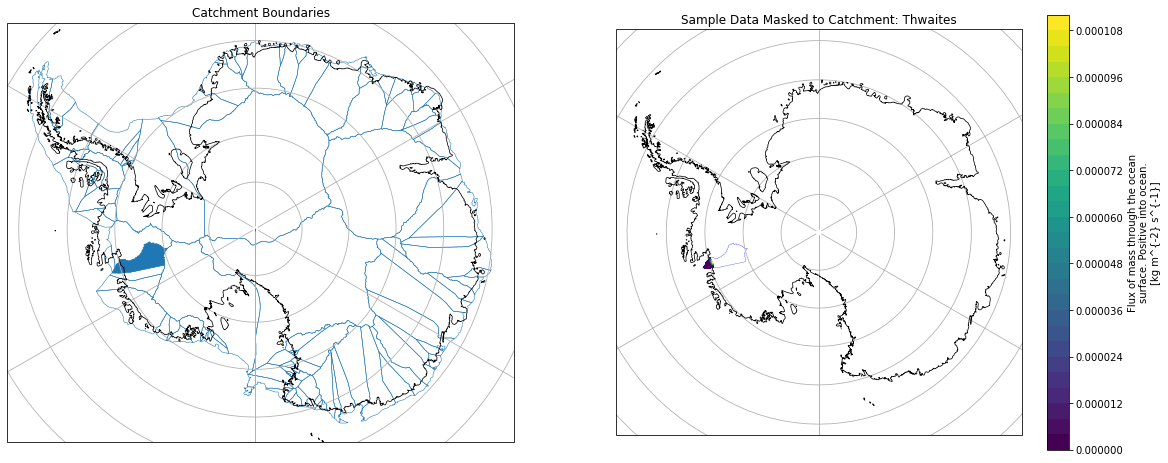

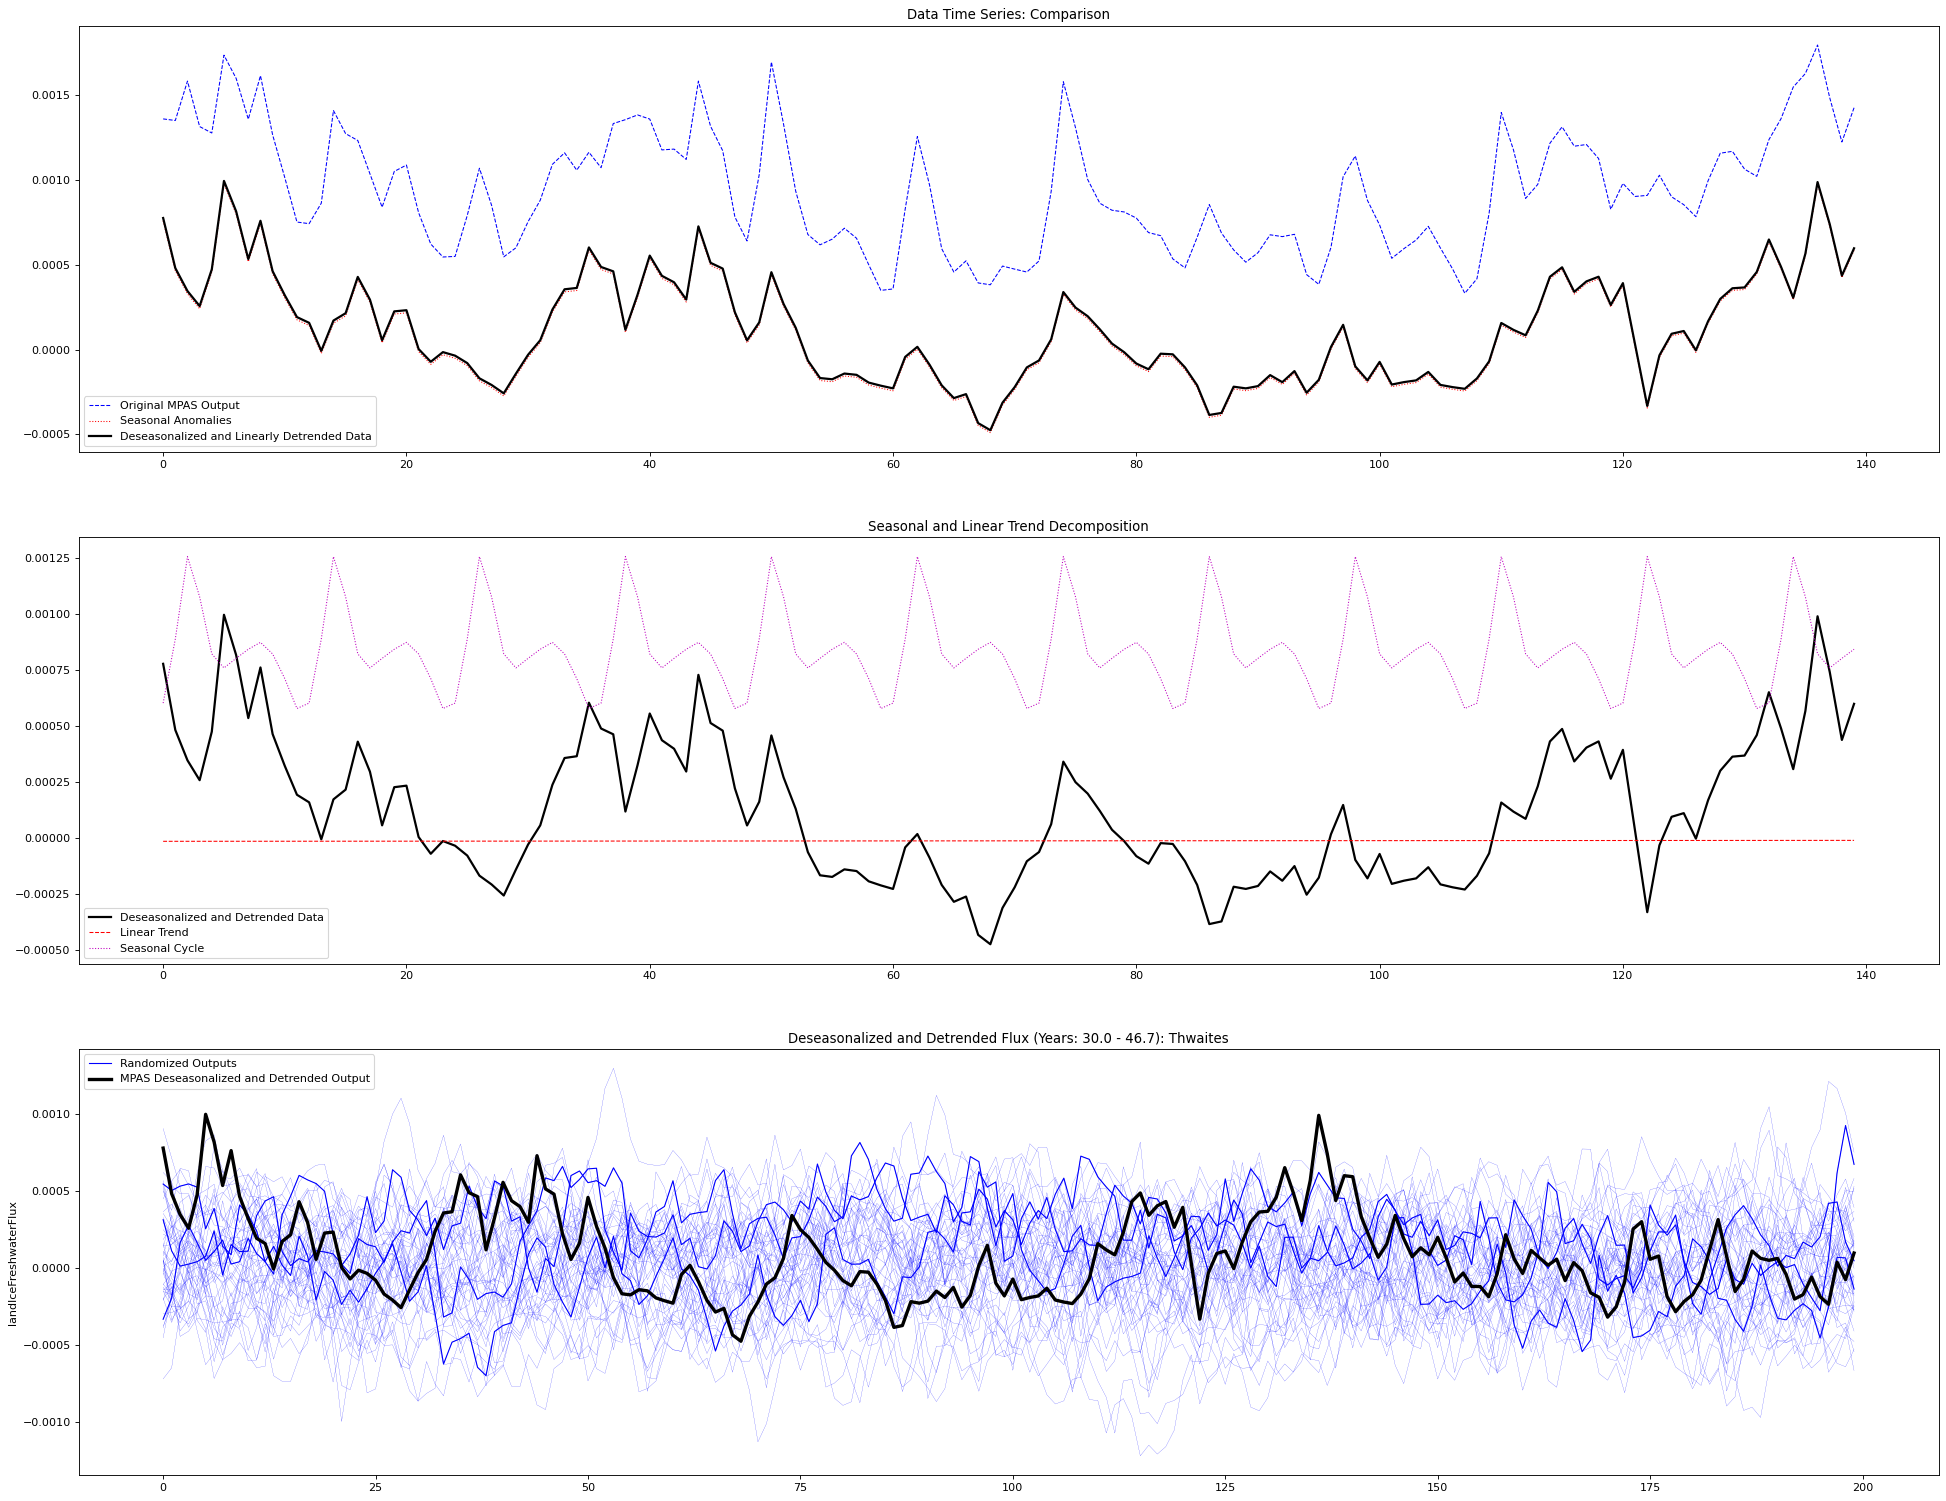

In [20]:
# Time Series Plotting Parameters
spinuptime = 60 # Ignore first few years of data in the time series and phase randomization plots, assumed model spinup
t1 = 300 # Initial time limit
tf = 500 # Final time limit, also used in the sample contourf plot


###########################################################
########## MAP PLOTS
###########################################################

plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[34:133].boundary.plot(ax=ax1,linewidth=0.5)
ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[basin]].plot(ax=ax1)
plt.title('Catchment Boundaries')

# Presents a sample plot of the ice shelf under question with the flux data at any time stamp

ax2 = plt.subplot(122,projection=ccrs.SouthPolarStereo())
ax2.gridlines()
ax2.coastlines(resolution='10m', zorder=3,linewidth=0.75)
flx[tf].plot.contourf(ax=ax2,levels=30,zorder=6)
icems.boundary.loc[[basin]].plot(ax=ax2,color='blue',linewidth=0.25)
plt.title('Sample Data Masked to Catchment: {}'.format(basinName))


###########################################################
########## TIME SERIES PLOTS
###########################################################
plt.figure(figsize=(30, 24), dpi=80)

plt.subplot(311)
plt.plot(flx_ts[(spinuptime+t1):tf], label='Original MPAS Output', color='b', linestyle='--', linewidth=0.95)
plt.plot(flx_anm_ts[(spinuptime+t1):tf], label='Seasonal Anomalies', color='r', linestyle='dotted', linewidth=0.95)
plt.plot(flx_dtr_ts[(spinuptime+t1):tf], label='Deseasonalized and Linearly Detrended Data', color='k', linewidth=2)
plt.legend()
plt.title('Data Time Series: Comparison')


plt.subplot(312)
plt.plot(flx_dtr_ts[(spinuptime+t1):tf], label='Deseasonalized and Detrended Data', color='k', linewidth=2)
plt.plot(flx_lnr_ts[(spinuptime+t1):tf], label='Linear Trend', color='r', linestyle='--', linewidth=0.95)
plt.plot(flx_snl_ts[(spinuptime+t1):tf], label='Seasonal Cycle', color='m', linestyle='dotted', linewidth=0.95)
plt.legend()
plt.title('Seasonal and Linear Trend Decomposition')

plt.subplot(313)

n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx_dtr_ts[spinuptime:].size))

for i in range(n_realizations):    
    fl = flx_dtr_ts[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Outputs')
plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Deseasonalized and Detrended Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

Text(0.5, 1.0, 'AIS Catchment Boundaries')

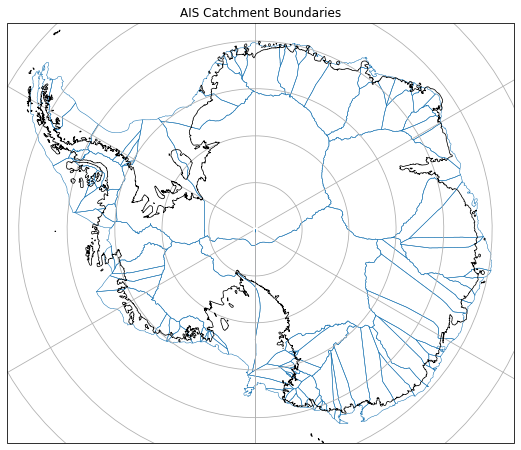

In [22]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[34:133].boundary.plot(ax=ax1,linewidth=0.5)
ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
#icems.loc[[basin]].plot(ax=ax1)
plt.title('AIS Catchment Boundaries')

In [ ]:
# Plot inset

fig = plt.figure(figsize=(10, 8), dpi=80)
ax = plt.axes()
ax.plot(flx_dtr_ts[60:1200])
plt.title('Raw Detrended Flux')

# Label the axis
ax.set_xlabel('Time')
ax.set_ylabel('Flux')


#I want to select the x-range for the zoomed region
x1 = 500
x2 = 800

# select y-range for zoomed region
y1 = -0.02
y2 = 0.05

# Make the zoom-in plot:
axins = zoomed_inset_axes(ax, 1, loc=1) # zoom = 2
axins.plot(flx_dtr_ts[60:1200])
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")